In [76]:
!gsutil ls gs://here-we-go/data

gs://here-we-go/data/
gs://here-we-go/data/Screen Shot 2020-04-29 at 6.24.23 PM.png
gs://here-we-go/data/monthly_index.csv
gs://here-we-go/data/countries/
gs://here-we-go/data/novel-corona-virus-2019-dataset/


In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, ArrayType, FloatType
from pyspark.sql.functions import isnan, when, count, col, sum, avg, expr, log, min, max, explode, split, udf, countDistinct, monotonically_increasing_id
from pyspark.sql.window import Window
import timeit 

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import numpy as np

In [3]:
def parse_country(country):
    
    """ 
    Reading stock data for a country and does some basic cleaning
    Available country list: ["britain", "china", "france", "india". "italy", "japan", "korea"]
    
    """
    # Access stored files from Google Storage
    bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")
    path = "gs://" + bucket + "/data/"
    
    temp = spark.read.format("csv")\
      .option("inferSchema", "true")\
      .option("header", "true")\
      .load(path+'countries/{}_daily_security.csv'.format(country))
    
    temp = temp.withColumn("date", col('datadate').cast("string"))\
        .withColumnRenamed("conm", "name")\
        .withColumnRenamed("curcdd", "price_currency")\
        .withColumnRenamed("cshoc", "shares_outstanding")\
        .withColumnRenamed("cshtrd", "trading_volume")\
        .withColumnRenamed("prccd", "price")\
        .withColumnRenamed("prchd", "price_high")\
        .withColumnRenamed("prcld", "price_low")\
        .withColumnRenamed("prcstd", "status_code")\
        .withColumnRenamed("divd", "dividends")\
        .withColumnRenamed("divrc", "capital_return")\
        .withColumnRenamed("trfd", "total_return_factor")\
        .withColumnRenamed("exchg", "exchange")\
        .withColumnRenamed("isin", "international_id")\
        .withColumnRenamed("secstat", "security_status")\
        .withColumnRenamed("tpci", "issue_type")\
        .withColumnRenamed("busdesc", "business_description")\
        .withColumnRenamed("costat", "active_indicator")\
        .withColumnRenamed("ggroup", "gic_group")\
        .withColumnRenamed("gind", "gic_industries")\
        .withColumnRenamed("gsector", "gic_sector")\
        .withColumnRenamed("gsubind", "gic_subindustries")\
        .withColumnRenamed("spcindcd", "sp_industry_sector")\
        .withColumnRenamed("spcseccd", "sp_economic_sector")\
        .withColumnRenamed("spcsrc", "sp_quality")\
        .withColumnRenamed("stko", "stock_ownership")\
        .filter(col("active_indicator") == "A")\
        .filter(col("security_status") == 'A')\
    
    #Variable explanations
    #https://wrds-web.wharton.upenn.edu/wrds/ds/compd/g_secd/index.cfm?navId=73
    # Dropped these since they are mostly missing, or redundant
    drop_col = ['dividends', 'capital_return', "cik", "sp_quality", "stock_ownership", 'sp_industry_sector'\
                ,'sp_economic_sector', 'datadate', 'price_high', 'price_low', 'international_id', 'business_description'\
                ,'active_indicator', 'security_status', 'datadate']
    
    # is it appropriate dropping na here? maybe forward the price, then drop
    temp = temp.drop(*drop_col).dropna()
    
    return add_features(temp)

def add_features(df):
    
    Windowspec=Window.partitionBy("gviid").orderBy("date")

    df = df \
        .withColumn('gviid', F.concat(F.col('gvkey'),F.lit('_'), F.col('iid')))\
        .withColumn("market_cap", F.col('shares_outstanding') * F.col('price'))\
        .withColumn('prev_day_price',F.lag(df['price']).over(Windowspec))   
                                  
    df = df.withColumn('return', (df['price'] - df['prev_day_price']) / df['prev_day_price'] ) \
        .drop("prev_day_price")
    
    return df

In [4]:
def country_summary(df):
    """ Basic summary of a country dataset, also initializes market subcategories
        Also returns a list of distinct sectors, industries, and groups
    """
    count = df.count()
    dates = df.select("date").distinct()
    start = dates.collect()[0][0]
    end = dates.orderBy(col("date").desc()).collect()[0][0]
    
    company = df.select("gvkey").distinct()
    sectors = df.select("gic_sector").distinct()
    industry = df.select("gic_industries").distinct()
    group = df.select("gic_group").distinct()
    universe = df.select("gviid").distinct()
   
    print("There are {} total entries. \nDate ranges from {} to {} \n{} distinct companies, {} industries, {} groups, and {} sectors" \
          .format(count, start, end, company.count(), industry.count(), group.count(), sectors.count()))

In [15]:
#country_list = ["britain", "china", "france", "india", "italy", "japan", "korea"]
numeric_cols = ['shares_outstanding', 'trading_volume', 'price', ]
indicator_cols = ['gvkey', 'iid', 'name', 'price_currency', 'status_code', 'gic_group', 'date']
#sec_list = [10, 25, 50, 15, 20, 40, 30, 55, 45, 60, 35]

target_index = 4
def main_run(country):
        
    t0 = timeit.default_timer()
    if country == "us":
        df = parse_us(country)
    else:
        df = parse_country(country)
    t1 = timeit.default_timer()
    print("It took {} seconds to read {} daily security for the past year".format(t1-t0, country))
    
    country_summary(df)
    df.printSchema()
    t2 = timeit.default_timer()
    print("it took {} seconds to calculate these statitics".format(t2-t1))
    return df

In [12]:
def stock_sample(df, gviid, target_cols):
    """ Creates a sample of the data for a specific asset only including target columns
        Params--
                gviid: string ID
                target_cols: list of strings of interested columns
    """
    return df.select(*target_cols).filter(col('gviid') == gviid)

def level_sample(df, level, target):
    """ 
        level: 0,1,2 respectively refers to: ["sector", "group", "industry"]
        target: a specific sector, group, or industry
        returns a sample of a t
    """
    
    level= ["sector", "group", "industry"]
    
    keys = ['gic_sector', 'gic_group', 'gic_industries']
    return df.where(col(keys[level])==target)

def single_plot(df, gviid, target):
    # make sure you only convert the necessar data to a pandas dataFrame: just data index and target should suffice
    # get x label using spark collect
    
    dat = stock_sample(df, gviid, ["date", "name", target]).toPandas() 
    dat = df.select("date", "name", target).where(col('gviid')==target)
    
    Y = dat[target]
    X = pd.to_datetime(dat['date']).values
    
    plt.plot(X,Y, label = dat["name"].values[0])
    plt.xlabel("Date");
    plt.ylabel(target);
    plt.legend()

    
# In hindsight this plot function could be super space inefficient
def multi_plot(df, keys, target, ax=None):
    """ Similar functionality to single_plot, plots multiple assets
        keys: a list of gviids that you want to plot
        ax: a plt axes
    """
    # filter stocks with multiple issuances
    t = ["date", "name", target]
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 10))
    for key in keys:
        if key.split('_')[1] == '01W':
            key_sample = df.select(*t).filter(col('gviid') == key).toPandas()
            #key_sample = stock_sample(df, key, t).toPandas()
            ax.plot(pd.to_datetime(key_sample['date']).values, key_sample[target], label = key_sample["name"].values[0])
    ax.set_label("Date")
    ax.set_title(target)
    """fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc='right', prop=fontP)"""
    return ax

def sector_plot(df, sec, target, ax=None):
    """ Generates plot for an entire sector for target
        sec is the 2 digit GIC sector code
    """
    # Get list of all gviids in sec
    #keys = df.select("gviid").where(col("gic_sector") == sec).distinct().toPandas()["gviid"].values
    #energy_list = list(italy.select("gviid").where(col("gic_sector") == 10).distinct().toPandas()["gviid"].values)
    sec_list = list(df.select("gviid").where(col("gic_sector") == sec).distinct().toPandas()["gviid"].values)
    return multi_plot(df, sec_list, target, ax)

In [7]:
# Prepare Italian banks data
bank_list = italy.select(col('gviid')).filter(col("gic_industries") == 401010).distinct()
banks = list(bank_list.toPandas().gviid.values)

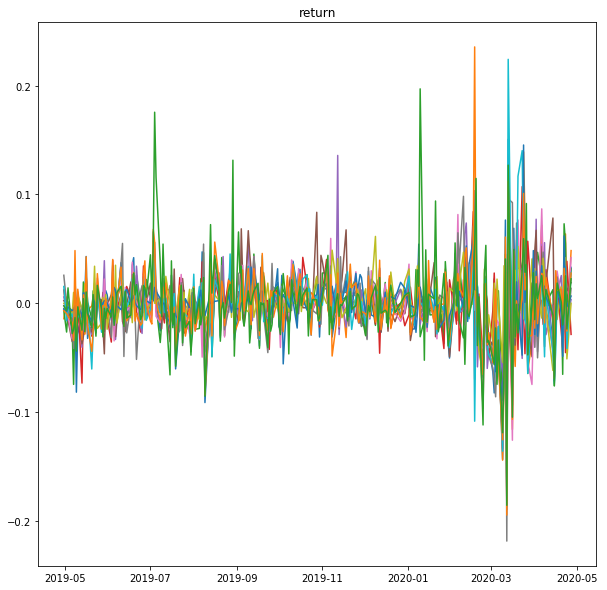

In [13]:
multi_plot(italy, banks, "return", None)

In [29]:
software_list = italy.select(col('gviid')).filter(col("gic_group") == 401010).distinct()
software = list(software_list.toPandas().gviid.values)

In [ ]:
def multi_plot(df, keys, target, ax=None):
    """ Similar functionality to single_plot, plots multiple assets
        keys: a list of gviids that you want to plot
        ax: a plt axes
    """
    # Need to filter out stocks that have multiple issuances
    t = ["date", "name", target]
    if ax == None:
        fig, ax = plt.subplots()
    for key in keys:
        if key.split('_')[1] == '01W':
            key_sample = stock_sample(df, key, t).toPandas()
            ax.plot(pd.to_datetime(key_sample['date']).values, key_sample[target], label = key_sample["name"].values[0])
    ax.set_label("Date")
    ax.set_title(target)
    """fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc='right', prop=fontP)"""
    return ax

def sector_plot(df, sec, target, ax=None):
    """ Generates plot for an entire sector for target
        sec is the 2 digit GIC sector code
    """
    # Get list of all gviids in sec
    keys = df.select("gviid").where(col("gic_sector") == sec).distinct().toPandas()["gviid"].values[:20]
    #energy_list = list(italy.select("gviid").where(col("gic_sector") == 10).distinct().toPandas()["gviid"].values)
    sec_list = list(df.select("gviid").where(col("gic_sector") == sec).distinct().toPandas()["gviid"].values)
    return multi_plot(df, sec_list, target, ax)
sector_codes = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
num_secs = len(sec_codes)
fig, axs = plt.subplots(num_secs, 1, figsize=(10,40))
for a in range(len(sector_codes)):
    sector_plot(italy.filter(col('date') > "20200000"), sector_codes[a], 'return', axs[a])
    axs[a].title.set_text("sector {}".format(sector_codes[a]))

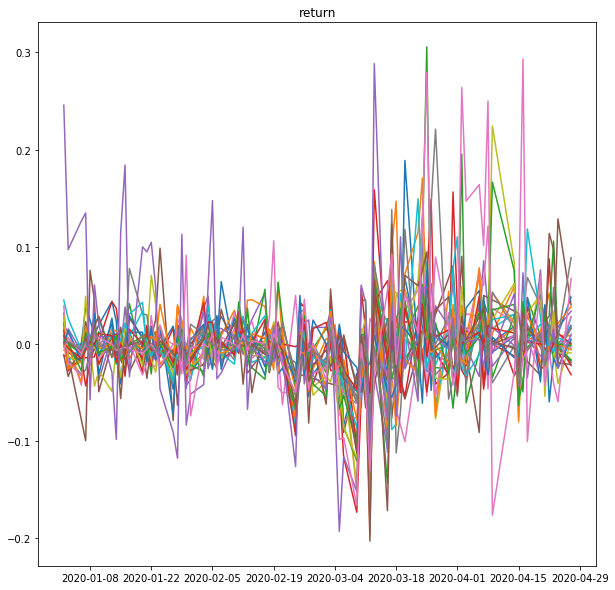

In [16]:
sector_plot(italy.filter(col('date') > "20200000"), 45, 'return')#.plot(figsize=(12, 8))
### bank sector italy

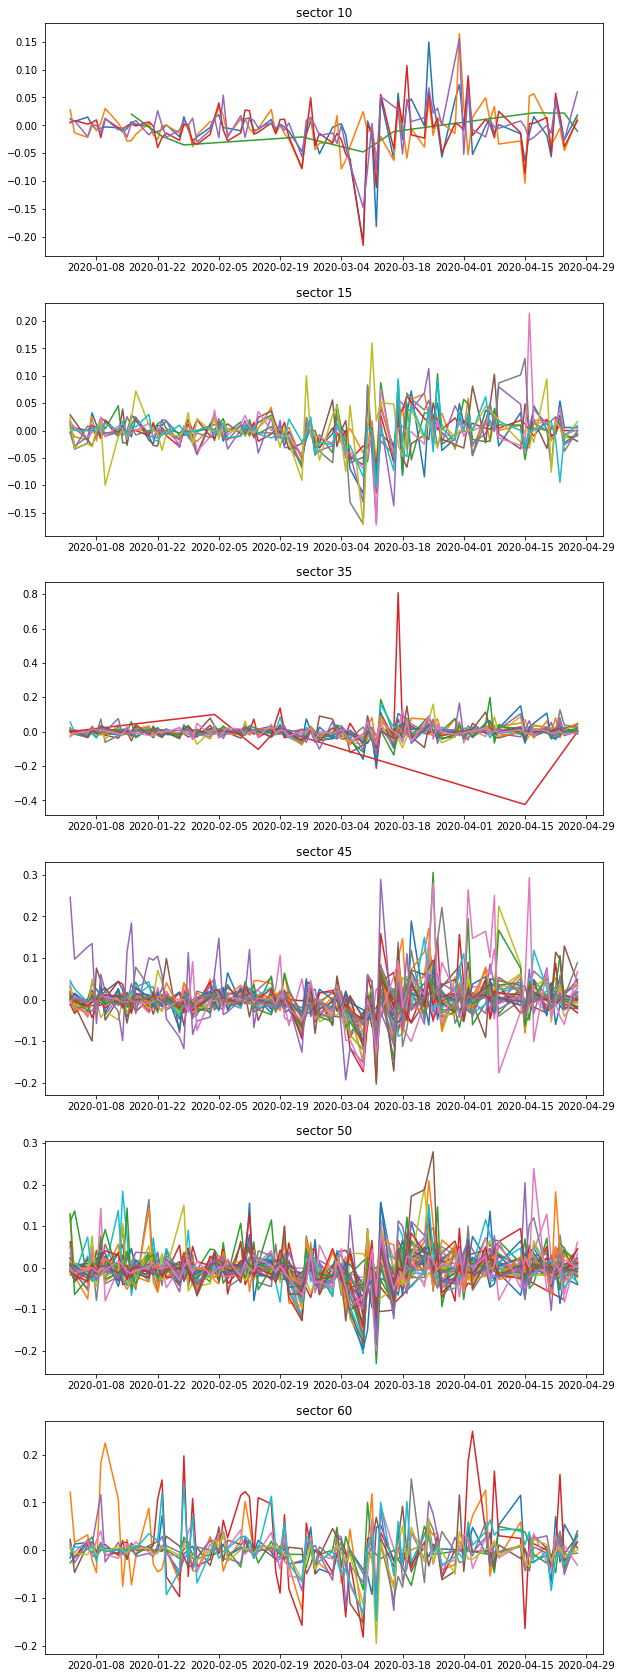

In [20]:
sector_codes = [10, 15, 35, 45, 50, 60]
num_secs = len(sector_codes)
fig, axs = plt.subplots(num_secs, 1, figsize=(10,30))
for a in range(len(sector_codes)):
    sector_plot(italy.filter(col('date') > "20200000"), sector_codes[a], 'return', axs[a])
    axs[a].title.set_text("sector {}".format(sector_codes[a]))

In [ ]:
sector_codes = [10, 15, 35, 45, 50, 60]
num_secs = len(sector_codes)
fig, axs = plt.subplots(num_secs, 1, figsize=(10,30), sharex=True)
for a in range(len(sector_codes)):
    sector_plot(japan.filter(col('date') > "20200000"), sector_codes[a], 'return', axs[a])
    axs[a].title.set_text("sector {}".format(sector_codes[a]))

In [185]:
def sector_index_return_transform(df, sec):
    """ Calculates market weighted index for each sector
    """
    temp = df.select("date", "gviid", "market_cap", "return").filter(col("gic_sector")==sec)
    
    daily_market_caps = temp.groupBy("date").agg(sum(col('market_cap')).alias("sector_cap"))
    
    nextdf = temp.join(daily_market_caps, "date").withColumn("sec_weight", col("market_cap") / col("sector_cap"))\
            .withColumn("sec_return", col('return') * col('sec_weight'))
    sec_index = nextdf.groupBy("date").agg(sum(col('sec_return')).alias("index_return"))
    
    return sec_index

def index_wrapper(df, Ax):
    """ Currently calculating for heath care industry
        Need to clean this up.
    """
    sec10 = sector_index_return_transform(df, 35)
    temp10 = sec10.toPandas()
    
    df = temp10.set_index('date')
    df.sort_index().cumsum().plot(ax=Ax)

In [24]:
t0 = timeit.default_timer()
britain = main_run("britan")
china = main_run("china")
india = main_run("india")
korea = main_run("korea")
france = main_run("france")
italy = main_run("italy")
japan = main_run("japan")
us = main_run('us')
t1 = timeit.default_timer()
print("It took {} seconds to read in and parse one years worth of daily stock data from 7 countries".format(t1-t0))

It took 26.16111367600024 seconds to read britan daily security for the past year
There are 347483 total entries. 
Date ranges from 20200218 to 20200427 
1157 distinct companies, 67 industries, 24 groups, and 11 sectors
root
 |-- gvkey: integer (nullable = true)
 |-- iid: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price_currency: string (nullable = true)
 |-- shares_outstanding: double (nullable = true)
 |-- trading_volume: double (nullable = true)
 |-- price: double (nullable = true)
 |-- status_code: integer (nullable = true)
 |-- qunit: double (nullable = true)
 |-- total_return_factor: double (nullable = true)
 |-- exchange: integer (nullable = true)
 |-- sedol: string (nullable = true)
 |-- issue_type: string (nullable = true)
 |-- gic_group: string (nullable = true)
 |-- gic_industries: string (nullable = true)
 |-- gic_sector: string (nullable = true)
 |-- gic_subindustries: string (nullable = true)
 |-- naics: string (nullable = true)
 |-- sic: string (nu

NameError: name 'parse_us' is not defined

In [ ]:
fig, ax = plt.subplots(7, 1, figsize=(10, 15), sharex=True, inplace=True)
t0 = timeit.default_timer()
index_wrapper(france.filter(col('date') >= "20191100"), ax[0])
index_wrapper(korea.filter(col('date') >= "20191100"), ax[1])
index_wrapper(china.filter(col('date') >= "20191100"), ax[2])   
index_wrapper(italy.filter(col('date') >= "20191100"), ax[3])
index_wrapper(britain.filter(col('date') >= "20191100"), ax[4])
index_wrapper(india.filter(col('date') >= "20191100"), ax[5])
index_wrapper(japan.filter(col('date') >= "20191100"), ax[6])
print("It took {} seconds to generate these graphs".format(timeit.default_timer() - t0))
### These are plots of returns for market-weighted energy index respectively for  
### France, Korea, China, Italy, Britain India, and japan!

It took 117.1707379690015 seconds to generate these graphs


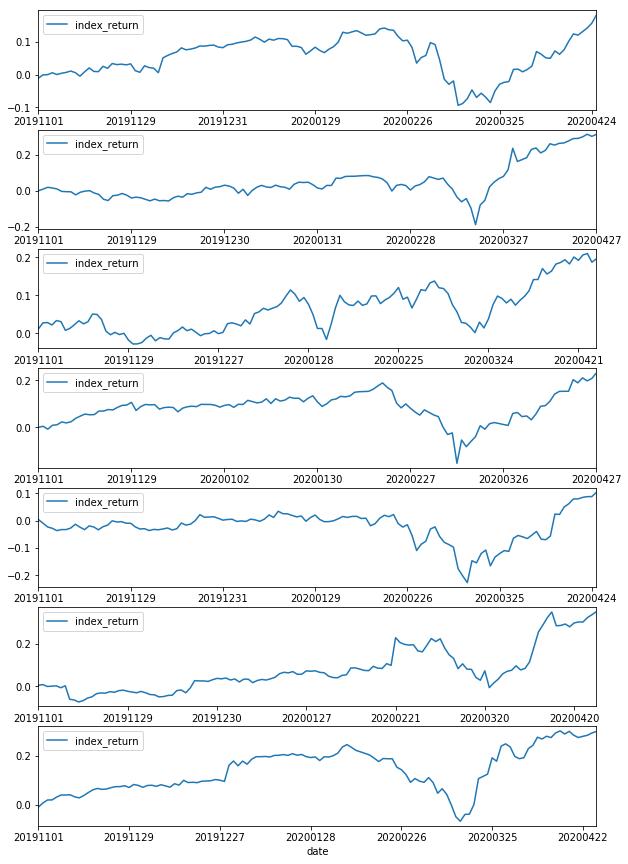

In [186]:
### Healthcare industrty
fig, ax = plt.subplots(7, 1, figsize=(10, 15))
t0 = timeit.default_timer()
index_wrapper(france.filter(col('date') >= "20191100"), ax[0])
index_wrapper(korea.filter(col('date') >= "20191100"), ax[1])
index_wrapper(china.filter(col('date') >= "20191100"), ax[2])   
index_wrapper(italy.filter(col('date') >= "20191100"), ax[3])
index_wrapper(britain.filter(col('date') >= "20191100"), ax[4])
index_wrapper(india.filter(col('date') >= "20191100"), ax[5])
index_wrapper(japan.filter(col('date') >= "20191100"), ax[6])
print("It took {} seconds to generate these graphs".format(timeit.default_timer() - t0))

Loading other countries in total it took around 3 minutes and run it through our parse_country function, but over 8 minutes to calculate some basic summary statistics. This shows the power of Sparks lazy transformation.

In [85]:
T0 = timeit.default_timer()
us = spark.read.format("csv")\
      .option("inferSchema", "true")\
      .option("header", "true")\
      .load("gs://here-we-go/data/countries/us_daily_security.csv")
T1 = timeit.default_timer()
print("It took Spark {} seconds to read the raw us daily file (3Gb)".format(T1-T0))

It took Spark 78.34066680599972 seconds to read the raw us daily file


In [190]:
!gsutil ls gs://here-we-go/data/novel-corona-virus-2019-dataset/

gs://here-we-go/data/novel-corona-virus-2019-dataset/.DS_Store
gs://here-we-go/data/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv
gs://here-we-go/data/novel-corona-virus-2019-dataset/covid_19_data.csv
gs://here-we-go/data/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
gs://here-we-go/data/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv
gs://here-we-go/data/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
gs://here-we-go/data/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv
gs://here-we-go/data/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv


In [191]:
# Read in death time series
# Didn't have to necessarily do this with Spark.
deaths = spark.read.format("csv")\
      .option("inferSchema", "true")\
      .option("header", "true")\
      .load("gs://here-we-go/data/novel-corona-virus-2019-dataset/covid_19_data.csv")

In [192]:
deaths.printSchema()

root
 |-- SNo: integer (nullable = true)
 |-- ObservationDate: string (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Last Update: string (nullable = true)
 |-- Confirmed: double (nullable = true)
 |-- Deaths: double (nullable = true)
 |-- Recovered: double (nullable = true)



In [193]:
deaths.show(5)

+---+---------------+--------------+--------------+---------------+---------+------+---------+
|SNo|ObservationDate|Province/State|Country/Region|    Last Update|Confirmed|Deaths|Recovered|
+---+---------------+--------------+--------------+---------------+---------+------+---------+
|  1|     01/22/2020|         Anhui|Mainland China|1/22/2020 17:00|      1.0|   0.0|      0.0|
|  2|     01/22/2020|       Beijing|Mainland China|1/22/2020 17:00|     14.0|   0.0|      0.0|
|  3|     01/22/2020|     Chongqing|Mainland China|1/22/2020 17:00|      6.0|   0.0|      0.0|
|  4|     01/22/2020|        Fujian|Mainland China|1/22/2020 17:00|      1.0|   0.0|      0.0|
|  5|     01/22/2020|         Gansu|Mainland China|1/22/2020 17:00|      0.0|   0.0|      0.0|
+---+---------------+--------------+--------------+---------------+---------+------+---------+
only showing top 5 rows



In [199]:
x = deaths.groupBy("ObservationDate").agg(sum(col('Deaths')).alias("daily_deaths"))#.show()#.orderby(col('ObservatioDate')).show()

In [204]:
y = x.orderBy(col("ObservationDate")).toPandas()

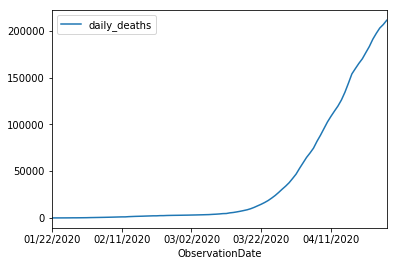

In [205]:
y.set_index('ObservationDate').plot(figsize=(8, 8))

In [206]:
us.printSchema()

root
 |-- gvkey: integer (nullable = true)
 |-- iid: string (nullable = true)
 |-- datadate: integer (nullable = true)
 |-- tic: string (nullable = true)
 |-- cusip: string (nullable = true)
 |-- conm: string (nullable = true)
 |-- capgn: double (nullable = true)
 |-- curcdd: string (nullable = true)
 |-- cshoc: double (nullable = true)
 |-- cshtrd: double (nullable = true)
 |-- eps: double (nullable = true)
 |-- prccd: double (nullable = true)
 |-- trfd: double (nullable = true)
 |-- exchg: integer (nullable = true)
 |-- secstat: string (nullable = true)
 |-- tpci: string (nullable = true)
 |-- ggroup: integer (nullable = true)
 |-- gind: integer (nullable = true)
 |-- gsector: integer (nullable = true)
 |-- gsubind: integer (nullable = true)
 |-- naics: integer (nullable = true)
 |-- sic: integer (nullable = true)
 |-- spcindcd: integer (nullable = true)
 |-- stko: integer (nullable = true)



In [207]:
italy.printSchema()

root
 |-- gvkey: integer (nullable = true)
 |-- iid: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price_currency: string (nullable = true)
 |-- shares_outstanding: double (nullable = true)
 |-- trading_volume: double (nullable = true)
 |-- price: double (nullable = true)
 |-- status_code: integer (nullable = true)
 |-- qunit: double (nullable = true)
 |-- total_return_factor: double (nullable = true)
 |-- exchange: integer (nullable = true)
 |-- sedol: string (nullable = true)
 |-- issue_type: string (nullable = true)
 |-- gic_group: integer (nullable = true)
 |-- gic_industries: integer (nullable = true)
 |-- gic_sector: integer (nullable = true)
 |-- gic_subindustries: integer (nullable = true)
 |-- naics: integer (nullable = true)
 |-- sic: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- gviid: string (nullable = true)
 |-- market_cap: double (nullable = true)
 |-- return: double (nullable = true)



In [25]:
def parse_us(country):
    
    """ 
    Reading stock data for a country and does some basic cleaning
    Available country list: ["britain", "china", "france", "india". "italy", "japan", "korea"]
    
    """
    # Access stored files from Google Storage
    bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")
    path = "gs://" + bucket + "/data/"
    
    temp = spark.read.format("csv")\
      .option("inferSchema", "true")\
      .option("header", "true")\
      .load(path+'countries/{}_daily_security.csv'.format(country))
    
    temp = temp.withColumn("date", col('datadate').cast("string"))\
        .withColumnRenamed("conm", "name")\
        .withColumnRenamed("curcdd", "price_currency")\
        .withColumnRenamed("cshoc", "shares_outstanding")\
        .withColumnRenamed("cshtrd", "trading_volume")\
        .withColumnRenamed("prccd", "price")\
        .withColumnRenamed("prchd", "price_high")\
        .withColumnRenamed("prcld", "price_low")\
        .withColumnRenamed("prcstd", "status_code")\
        .withColumnRenamed("divd", "dividends")\
        .withColumnRenamed("divrc", "capital_return")\
        .withColumnRenamed("trfd", "total_return_factor")\
        .withColumnRenamed("exchg", "exchange")\
        .withColumnRenamed("isin", "international_id")\
        .withColumnRenamed("secstat", "security_status")\
        .withColumnRenamed("tpci", "issue_type")\
        .withColumnRenamed("busdesc", "business_description")\
        .withColumnRenamed("ggroup", "gic_group")\
        .withColumnRenamed("gind", "gic_industries")\
        .withColumnRenamed("gsector", "gic_sector")\
        .withColumnRenamed("gsubind", "gic_subindustries")\
        .withColumnRenamed("spcindcd", "sp_industry_sector")\
        .withColumnRenamed("spcseccd", "sp_economic_sector")\
        .withColumnRenamed("spcsrc", "sp_quality")\
        .withColumnRenamed("stko", "stock_ownership")\
        .filter(col("security_status") == 'A')\
    
    #Variable explanations
    #https://wrds-web.wharton.upenn.edu/wrds/ds/compd/g_secd/index.cfm?navId=73
    # Dropped these since they are mostly missing, or redundant
    drop_col = ['dividends', 'capital_return', "cik", "sp_quality", "stock_ownership", 'sp_industry_sector'\
                ,'sp_economic_sector', 'datadate', 'price_high', 'price_low', 'international_id', 'business_description'\
                ,'active_indicator', 'security_status', 'datadate']
    
    # is it appropriate dropping na here? maybe forward the price, then drop
    temp = temp.drop(*drop_col).dropna()

In [ ]:
us = main_run('us')